# Machine Learning Tutorial 

The naive Bayes multiclass approach is an extension of the naive Bayes approach. It can be trained to output binary images given an input color image. Unlike the naive Bayes method, the naive Bayes multiclass approach can be trained to classify two or more classes, defined by the user. Additionally, the naive Bayes multiclass method is trained using colors sparsely sampled from images rather than the need to label all pixels in a given image.

To train the classifier, we need to build a table of red, green, and blue color values for pixels sampled evenly from each class. The idea here is to collect a relevant sample of pixel color data for each class. The size of the sample needed to build robust probability density functions for each class will depend on a number of factors, including the variability in class colors and imaging quality/reproducibility. To collect pixel color data we currently use the Pixel Inspection Tool in [ImageJ](https://imagej.nih.gov/ij/). Each column in the tab-delimited table is a feature class (in this example, plant, pustule, chlorosis, or background)
and each cell is a comma-separated red, green, and blue triplet for a pixel.





Once a satisfactory sample of pixels is collected, save the table as a tab-delimited text file. Use `plantcv-train.py` to use the pixel samples to output probability density functions (PDFs)
for each class.

plantcv-train.py naive_bayes_multiclass --file pixel_samples.txt --outfile naive_bayes_pdfs.txt --plots

The output file from `plantcv-train.py` will contain one row for each color channel (hue, saturation, and value) for
each class. The first and second column are the class and channel label, respectively. The
remaining 256 columns contain the p-value from the PDFs for each intensity value observable in an 8-bit image (0-255).

Once we have the `plantcv-train.py` output file, we can classify pixels in a color image in PlantCV. In the example image for this tutorial we have already collected pixels and created the probability density functions for each class. 

In [ ]:
#%pip install plantcv

In [1]:
# Import libraries

import cv2
from plantcv import plantcv as pcv


In [ ]:
#plantcv-train.py SE CORRE PREVIAMENTE DESDE LA CONSOLA

In [37]:
class options:
    def __init__(self):
        self.image = "./img/2_1.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "ml_tutorial_results.json"
        self.outdir = "."

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


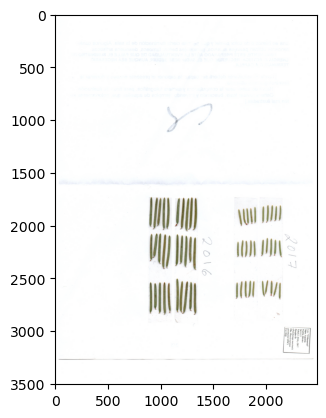

In [38]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)


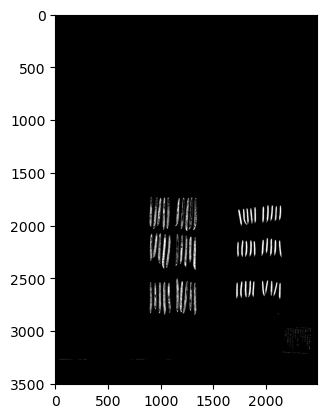

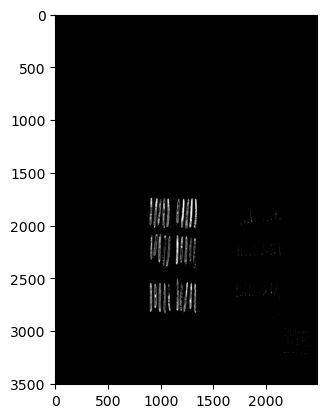

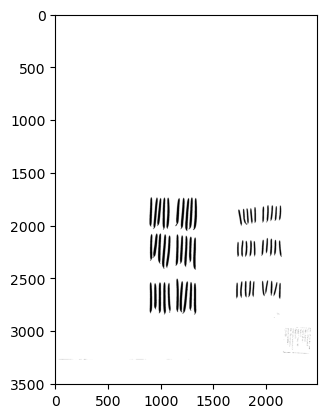

In [39]:
# Use the output file from `plantcv-train.py` to run the multiclass 
# naive bayes classification on the image. The function below will 
# print out 4 masks (plant, pustule, chlorosis, background)

# Inputs: 
#   rgb_img - RGB image data 
#   pdf_file - Output file containing PDFs from `plantcv-train.py`
mask = pcv.naive_bayes_classifier(rgb_img=img, 
                                  pdf_file="./img/naive_bayes_pdfs.txt")


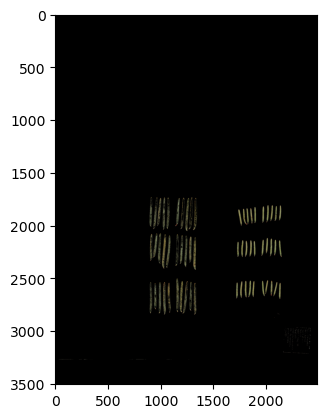

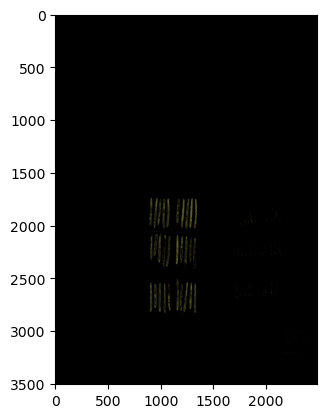

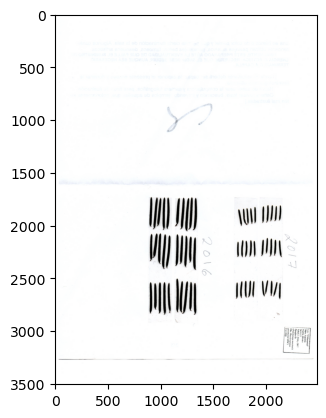

In [40]:
# We can apply each mask to the original image to more accurately 
# see what got masked

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
sana_img = pcv.apply_mask(mask=(mask['sanas']), img=img, mask_color='black')
enferma_img = pcv.apply_mask(mask=(mask['enfermas']), img=img, mask_color='black')
papel_img = pcv.apply_mask(mask=(mask['papel']), img=img, mask_color='black')


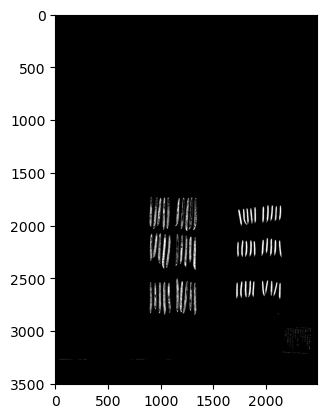

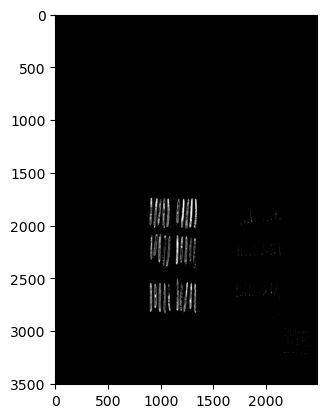

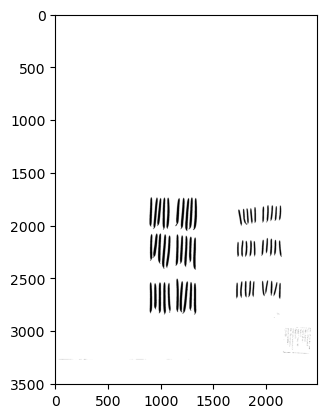

In [41]:
# Write image and mask with the same name to the path 
# specified (creates two folders within the path if they do not exist).

# Inputs: 
#   img - RGB or grayscale image data, original image 
#   mask - Binary mask image created 
#   filename - Image filename to get saved as
#   outdir - Output directory (default: None)
#   mask_only - Defaults to False, if True then only outputs mask 
sanas_maskpath, sanas_analysis_images = pcv.output_mask(img=img, mask=mask['sanas'], 
                                                        filename='sanas.png', mask_only=True)
enfermas_maskpath, enfermas_analysis_images = pcv.output_mask(img=img, mask=mask['enfermas'], 
                                                      filename='enfermas.png', mask_only=True)
papel_maskpath, papel_analysis_images = pcv.output_mask(img=img, mask=mask['papel'], 
                                                        filename='papel.png', mask_only=True)



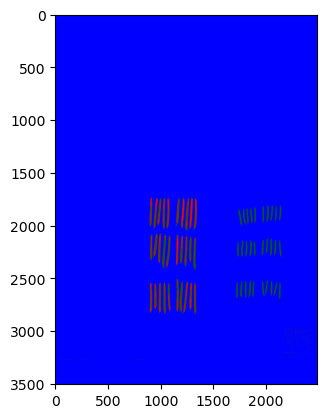

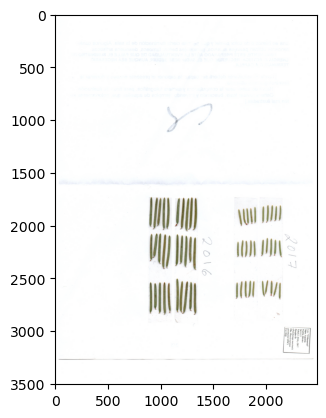

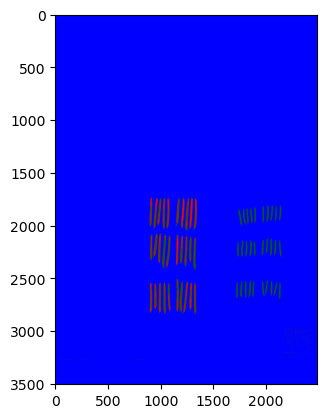

In [42]:
# To see all of these masks together we can plot them with plant set to green,
# chlorosis set to gold, and pustule set to red.

# Inputs:
#   masks - List of masks (the different classes returned by naive_bayes_classifier)
#   colors - List of colors to assign to each class. Users can either provide a 
#   list of color names (str) or can provide tuples of custom BGR values
classified_img = pcv.visualize.colorize_masks(masks=[mask['sanas'], mask['enfermas'], 
                                                     mask['papel']], 
                                              colors=['dark green', 'red', 'blue'])

classified_img_export = pcv.output_mask(img=img, mask= classified_img, 
                                                        filename='segmentadas.png')

In [48]:
import numpy as np

# Calculate percent of the plant found to be diseased 
sick_plant = np.count_nonzero(mask['enfermas']) #+ np.count_nonzero(mask['papel'])
healthy_plant = np.count_nonzero(mask['sanas'])
percent_diseased = sick_plant / (sick_plant + healthy_plant)
percent_diseased


0.33131874827917723

In [44]:
# Create a new measurement (gets saved to the outputs class) 

# Inputs:
#    sample - A sample name or label
#    variable - The name of the variable for the observation to get stored. Must be unique to other variable names
#               since data is a dictionary format where variable is the key.
#    trait - Description of the observation getting stored
#    method - Description of the method for calculating the observation
#    scale - Observation scale
#    datatype - The datatype of the observation, most commonly either bool, str, int, float, list 
#    value - Value of the observation getting stored
#    label - Label for the observation getting stored. Required for list datatype observations. 
pcv.outputs.add_observation(sample='default', variable='percent_diseased', trait='percent of plant detected to be diseased',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_diseased, label='percent')



In [45]:
# Data stored to the outputs class can be accessed using the variable name
pcv.outputs.observations['default']['percent_diseased']['value']


0.33131874827917723

In [46]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.outputs.save_results(filename=args.result)


To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner.
2) Click “Open…”
3) CLick on the file named “ml_tutorial_results.txt”

Check out documentation on how to [convert JSON](https://plantcv.readthedocs.io/en/latest/tools/#convert-output-json-data-files-to-csv-tables) format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits). 
